# พลอตข้อมูล anomaly ของอุณหภูมิจากข้อมูล ERA5
* แบบฝึกหัดนี้นิสิตจะได้ฝึกหัด
    * การดาวน์โหลดข้อมูล ERA5
    * การอ่านข้อมูล ERA5 เข้ามาใน XARRAY
    * การพลอตแผนที่อุณหภูมิที่ระดับ 850 hPa ของเดือนที่นิสิตสนใจ
    * การคำนวณค่าอุณหภูมิเฉลี่ยเชิงภูมิอากาศวิทยา
    * การคำนวณค่า anomaly temperature
    

* ข้อมูล ERA5 ดาวน์โหลดมาจาก https://cds.climate.copernicus.eu/#!/home โดยเข้าไปที่ลิงก์ https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview เป็นข้อมูลที่รวมกันระหว่างข้อมูลที่ตรวจวัดจริงจากหลายเครื่องมือ เช่น ดาวเทียม บอลลูน ทุ่น เป็นต้น ร่วมกันกับแบบจำลอง https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Observations
    * ข้อมูลมีความละเอียดรายชั่วโมง (hourly)หากแต่ในแบบฝึกหัดนี้เลือกข้อมูล "ERA5 monthly averaged data on pressure levels from 1979 to present" ซึ่งเป็นการเฉลี่ยรายเดือนในแต่ละระดับความกดบรรยากาศ นิสิตสามารถนำข้อมูล hourly มาทำเฉลี่ยให้เป็นข้อมูลรายวันได้ด้วยการใช้ Numpy  หรือ XARRAY (ง่ายกว่า)


* ข้อมูลที่ใช้ในแบบฝึกหัดนี้ประกอบด้วย 40 ปี ของสองเดือน คือ เดือนมกราคมและกรกฎาคม ใช้ระดับความกดอากาศที่ 850 hPa

* สูตรในการคำนวณ anomalies https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/anomalies.html นั่นคือ anomaly = X -Climatological mean


## 1. อ่านไลบราลี

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

In [2]:
df = xr.open_dataset('era5_monthly_mean_globe.nc')
print(df)
# สังเกตุว่าข้อมูลที่อ่านเข้ามาเป็น Dataset

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 80)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-01-01 1981-07-01 ... 2020-07-01
Data variables:
    z          (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-07 04:35:51 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...


## 2.เก็บค่าตัวแปรที่ต้องการนำไปใช้งาน

In [3]:
lon_ = df.longitude
lat_ = df.latitude
time_  = df.time
temp_  = df.t #อุณหภูมิ
print(temp_.shape)

(80, 721, 1440)


In [4]:
print(time_)

<xarray.DataArray 'time' (time: 80)>
array(['1981-01-01T00:00:00.000000000', '1981-07-01T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1982-07-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1983-07-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1984-07-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1985-07-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1986-07-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1987-07-01T00:00:00.000000000',
       '1988-01-01T00:00:00.000000000', '1988-07-01T00:00:00.000000000',
       '1989-01-01T00:00:00.000000000', '1989-07-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1990-07-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-07-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1992-07-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1993-07-01T00:00:00.000000000',
       '1994-0

In [5]:
print(time_[0].values)

1981-01-01T00:00:00.000000000


In [6]:
print(time_[-1].values)

2020-07-01T00:00:00.000000000


In [7]:
print(lon_)

<xarray.DataArray 'longitude' (longitude: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    units:      degrees_east
    long_name:  longitude


In [8]:
print(lat_)

<xarray.DataArray 'latitude' (latitude: 721)>
array([ 90.  ,  89.75,  89.5 , ..., -89.5 , -89.75, -90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude


(80, 721, 1440)


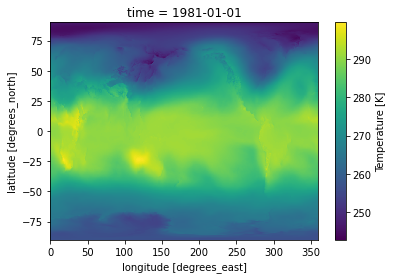

In [9]:
print(temp_.shape)
temp_[0,:,:].plot()

In [10]:
temp_

<xarray.DataArray 't' (time: 80, latitude: 721, longitude: 1440)>
[83059200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-01-01 1981-07-01 ... 2020-07-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

## 3. พลอตข้อมูลอุณหภูมิเดือนที่สนใจ ด้วยการเลือกช่วงเวลา

### 3.1 อุณหภูมิเดือนกรกฎาคม 2011

In [11]:
temperature=temp_.sel(time='2011-07-01') # อุณหภูมิเดือนกรกฎาคม

In [12]:
temperature

<xarray.DataArray 't' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2011-07-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [13]:
temperature_jul=temperature-273.15 #แปลงเคลวินเป็นเซลเซียส

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\cr

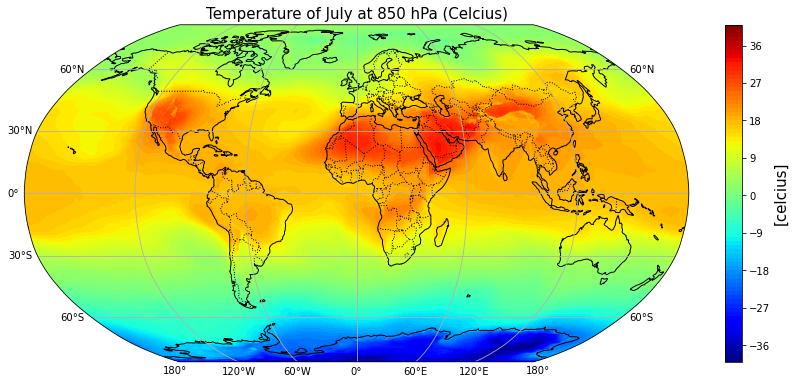

In [14]:
## พลอตแผนที่อุณหภูมิของเดือนที่สนใจ ระดับความกดบรรยากาศ 850 hPa  
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeat

plt.figure(figsize=(13,6.2))
uw_cyc, lon_cyc = add_cyclic_point(temperature_jul, coord=lon_) #Changing the longitude from 0º – 360º to -180 – 180 จาก https://geoclimatologyblog.wordpress.com/page/2/


ax = plt.subplot(111, projection=ccrs.Robinson())
#max_ = np.round((np.max(uw_cyc)))+2
#min_ = np.round((np.min(uw_cyc)))
max_ = 42
min_ = -40
vstep = 1.0
levels = np.arange(min_, max_, vstep)
temperature_ = ax.contourf(lon_cyc,\
                                 lat_,\
                                 uw_cyc,\
                                 levels,\
                                 transform=ccrs.PlateCarree(),\
                                 cmap='jet')


ax.coastlines(resolution='110m', color='black', linewidth=1) #เพิ่มแนวชายฝั่งจาก pyplot
ax.add_feature(cfeat.BORDERS, linestyle=':') #เพิ่มขอบเขตประเทศจาก cartopy

#เซตค่าชื่อกริด การแสดงกริดเส้นโครง
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#พลอต color bar
# คำนวณมิติข้อมูล (height_of_image / width_of_image)
im_ratio = uw_cyc.shape[0]/uw_cyc.shape[1]
cbar = plt.colorbar(temperature_,fraction=0.047*im_ratio)
cbar.set_label('[celcius]', fontsize=15)


plt.title('Temperature of July at 850 hPa (Celcius)', fontsize=15)
plt.show()

### ให้นิสิตทดลองพลอตอุณหภูมิเดือนมกราคม

### 3.2 อุณหภูมิเดือนมกราคม 2011

In [15]:
temperature=temp_.sel(time='2011-01-01') # อุณหภูมิเดือนมกราคม

In [16]:
temperature_jan=temperature-273.15

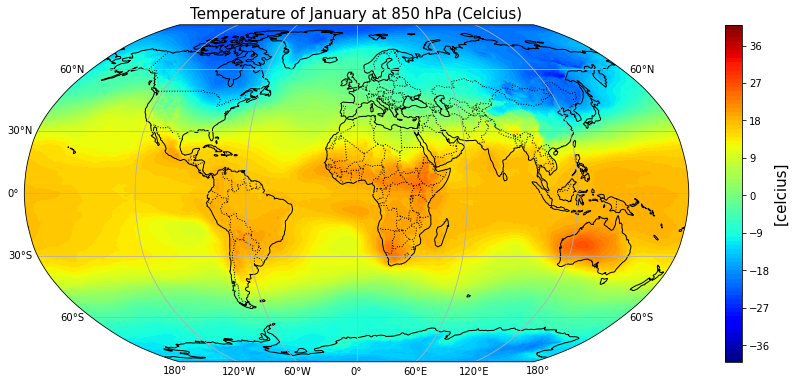

In [17]:
## พลอตแผนที่อุณหภูมิของเดือนที่สนใจ ระดับความกดบรรยากาศ 850 hPa  
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeat

plt.figure(figsize=(13,6.2))
uw_cyc, lon_cyc = add_cyclic_point(temperature_jan, coord=lon_) #Changing the longitude from 0º – 360º to -180 – 180 จาก https://geoclimatologyblog.wordpress.com/page/2/


ax = plt.subplot(111, projection=ccrs.Robinson())
#max_ = np.round((np.max(uw_cyc)))+2
#min_ = np.round((np.min(uw_cyc)))
max_ = 42
min_ = -40
vstep = 1.0
levels = np.arange(min_, max_, vstep)
temperature_ = ax.contourf(lon_cyc,\
                                 lat_,\
                                 uw_cyc,\
                                 levels,\
                                 transform=ccrs.PlateCarree(),\
                                 cmap='jet')


ax.coastlines(resolution='110m', color='black', linewidth=1) #เพิ่มแนวชายฝั่งจาก pyplot
ax.add_feature(cfeat.BORDERS, linestyle=':') #เพิ่มขอบเขตประเทศจาก cartopy

#เซตค่าชื่อกริด การแสดงกริดเส้นโครง
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#พลอต color bar
# คำนวณมิติข้อมูล (height_of_image / width_of_image)
im_ratio = uw_cyc.shape[0]/uw_cyc.shape[1]
cbar = plt.colorbar(temperature_,fraction=0.047*im_ratio)
cbar.set_label('[celcius]', fontsize=15)


plt.title('Temperature of January at 850 hPa (Celcius)', fontsize=15)
plt.show()

## 4.คำนวณหาค่าอุณหภูมิเฉลี่ยเชิงภูมิอากาศวิทยา 30 ปี ตั้งแต่ 1991-2020 ของเดือนกรกฏาคม

In [18]:
# เลือกโดยใช้วิธีการ groups ใน xarray เอาเฉพาะเดือนมาก่อน เพื่อให้ได้ index เดือนมา
month_idxs=df.groupby('time.month').groups
# สกัดค่า index ของเดือนที่ต้องการ ในที่นี้ใช้ 7 แทนเดือนกรกฏาคม เนื่องจาก 1 คือเดือนมกราคม
jul_idxs=month_idxs[7]
# เมื่อได้ค่า index ของเดือนกรกฎาคม ให้นำมาใช้สกัดข้อมูลเดือนกรกฎาคมได้เลย
ds_jul=df.isel(time=jul_idxs)

In [19]:
ds_jul

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 40)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-07-01 1982-07-01 ... 2020-07-01
Data variables:
    z          (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-07 04:35:51 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [20]:
temp_  = ds_jul.t #อุณหภูมิ

In [21]:
temp_

<xarray.DataArray 't' (time: 40, latitude: 721, longitude: 1440)>
[41529600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-07-01 1982-07-01 ... 2020-07-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [22]:
temp_30yrs = temp_.loc['1991-07':'2020-07']

In [23]:
temp_30yrs.shape

(30, 721, 1440)

In [24]:
# หาค่า mean เนื่องจากตอนนี้ข้อมูลเป็นแบบ data array จึงต้องใช้คำสั่งใน numpy แต่ถ้าเป็น dataset จะใช้ของ xarray ได้เลย
temp_30yrs_mean = np.mean(temp_30yrs,axis=0)
temp_30yrs_mean.shape

(721, 1440)

In [25]:
temp_30yrs_mean = temp_30yrs_mean - 273.15

### พลอตแผนที่อุณหภูมิเฉลี่ยเชิงภูมิอากาศวิทยา 30 ปี ตั้งแต่ 1991-2020 ของเดือนกรกฏาคม

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\cr

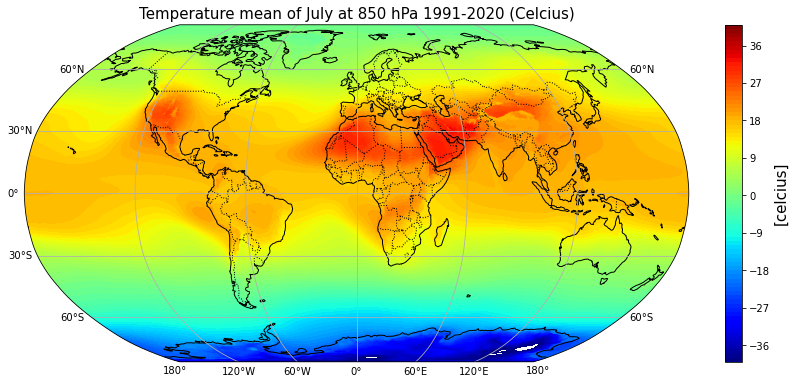

In [26]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeat

plt.figure(figsize=(13,6.2))
uw_cyc, lon_cyc = add_cyclic_point(temp_30yrs_mean, coord=lon_) #Changing the longitude from 0º – 360º to -180 – 180 จาก https://geoclimatologyblog.wordpress.com/page/2/


ax = plt.subplot(111, projection=ccrs.Robinson())
#max_ = np.round((np.max(uw_cyc)))+2
#min_ = np.round((np.min(uw_cyc)))
max_ = 42
min_ = -40
vstep = 1.0
levels = np.arange(min_, max_, vstep)
temperature_ = ax.contourf(lon_cyc,\
                                 lat_,\
                                 uw_cyc,\
                                 levels,\
                                 transform=ccrs.PlateCarree(),\
                                 cmap='jet')


ax.coastlines(resolution='110m', color='black', linewidth=1) #เพิ่มแนวชายฝั่งจาก pyplot
ax.add_feature(cfeat.BORDERS, linestyle=':') #เพิ่มขอบเขตประเทศจาก cartopy

#เซตค่าชื่อกริด การแสดงกริดเส้นโครง
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#พลอต color bar
# คำนวณมิติข้อมูล (height_of_image / width_of_image)
im_ratio = uw_cyc.shape[0]/uw_cyc.shape[1]
cbar = plt.colorbar(temperature_,fraction=0.047*im_ratio)
cbar.set_label('[celcius]', fontsize=15)


plt.title('Temperature mean of July at 850 hPa 1991-2020 (Celcius)', fontsize=15)
plt.show()

## 5.พลอตค่า temperature anomaly ของปี 2011 เทียบกับค่าอุณหภูมิเฉลี่ยเชิงภูมิอากาศ 30 ปี ของเดือนกรกฎาคม

In [27]:
anomaly_jul=temperature_jul-temp_30yrs_mean

In [28]:
anomaly_jul

<xarray.DataArray 't' (latitude: 721, longitude: 1440)>
array([[3.865387 , 3.865387 , 3.865387 , ..., 3.865387 , 3.865387 ,
        3.865387 ],
       [3.8718262, 3.8718262, 3.8718262, ..., 3.8726807, 3.8728333,
        3.8730164],
       [3.8628845, 3.8630066, 3.8632812, ..., 3.865265 , 3.865265 ,
        3.8628235],
       ...,
       [2.2177124, 2.2209015, 2.2229004, ..., 2.2110596, 2.2135773,
        2.2155151],
       [2.2438965, 2.2463074, 2.2461243, ..., 2.240387 , 2.2413635,
        2.241333 ],
       [2.0525055, 2.0525055, 2.0525055, ..., 2.0525055, 2.0525055,
        2.0525055]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2011-07-01

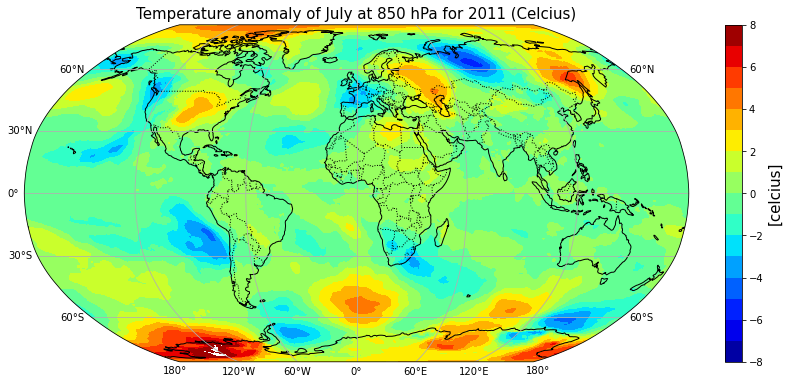

In [29]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeat

plt.figure(figsize=(13,6.2))
uw_cyc, lon_cyc = add_cyclic_point(anomaly_jul, coord=lon_) #Changing the longitude from 0º – 360º to -180 – 180 จาก https://geoclimatologyblog.wordpress.com/page/2/


ax = plt.subplot(111, projection=ccrs.Robinson())
#max_ = np.round((np.max(uw_cyc)))+2
#min_ = max_*(-1)
max_ =9
min_ = -8
vstep = 1.0
levels = np.arange(min_, max_, vstep)
temperature_ = ax.contourf(lon_cyc,\
                                 lat_,\
                                 uw_cyc,\
                                 levels,\
                                 transform=ccrs.PlateCarree(),\
                                 cmap='jet')


ax.coastlines(resolution='110m', color='black', linewidth=1) #เพิ่มแนวชายฝั่งจาก pyplot
ax.add_feature(cfeat.BORDERS, linestyle=':') #เพิ่มขอบเขตประเทศจาก cartopy

#เซตค่าชื่อกริด การแสดงกริดเส้นโครง
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#พลอต color bar
# คำนวณมิติข้อมูล (height_of_image / width_of_image)
im_ratio = uw_cyc.shape[0]/uw_cyc.shape[1]
cbar = plt.colorbar(temperature_,fraction=0.047*im_ratio)
cbar.set_label('[celcius]', fontsize=15)


plt.title('Temperature anomaly of July at 850 hPa for 2011 (Celcius)', fontsize=15)
plt.show()

#### แปลผล 
* ค่ามีทั้งบวกและลบ สนใจเฉพาะค่าที่สูง
* ค่าบวกมากๆ แสดงถึงอุณหภูมิของเดือนกรกฎาคมเบี่ยงเบนหรือมีค่าผิดปรกติไปจากค่าอุณหภูมิเฉลี่ยเชิงภูมิอากาศวิทยา
* ค่าบวกที่มาก เกิดขึ้นในพื้นแผ่นดิน จะส่งผลกระทบต่อผู้คนโดยตรง เนื่องจากเดือนที่วิเคราะห์คือเดือนกรกฎาคม อยู่ในช่วงฤดูร้อนของซีกโลกเหนือ พบว่ามีพื้นที่ที่มีอุณหภูมิสูงกว่าค่าเฉลี่ยเชิงภูมิอากาศ เช่นในทางตอนกลางของประเทศสหรัฐอเมริกา ประเทศรัฐเซียและทางไซบีเรีย อุณหภูมิ anomaly ที่มีค่าเป็นบวกที่สูงมาก แสดงถึงอุณหภูมิเดือนกรกฏาคม ปี 2011 สูงกว่าค่าเฉลี่ยเชิงภูมิอากาศวิทยาอย่างมาก
* ในขณะที่ตอนกลางของรัสเซียพบว่า anomaly ที่เป็นติดลบที่มาก ซึ่งเกิดจากอุณหภูมิของปี 2011 ต่ำกว่าค่าเฉลี่ยมาก เมื่อนำมาลบกันจึงได้ค่า anomaly ที่มีค่าติดลบที่มาก
* ข้อสังเกตุ เนื่องจากการวิเคราะห์ในแบบฝึกหัดนี้ใช้อุณหภูมิที่ระดับ 850 hPa หากจะให้ได้ผลการวิเคราะห์ที่ดีกว่านี้ต้องใช้ surface temperature


#### ให้นิสิตทดลองทำ/ทดลองคิด
1. ทำการวิเคราะห์และแปลผล anomaly ของเดือนมกราคม ปี 2011 
2. นิสิตลองดาวน์โหลดข้อมูล surface temperature แล้วลองหาเหตุการณ์ที่รุนแรงของอุณหภูมิพื้นผิวหรือคลื่นความร้อน เพื่อนำมาวิเคราะห์ปรากฏการณ์ มักพบว่ามีข่าวในต่างประเทศที่อยู่ในเขตละติจูดกลาง เช่นในยุโรปหรือสหรัฐอเมริกา ที่มักได้รับผลกระทบจากคลื่นความร้อน heat wave
3. นิสิตลองคิดหน่อยว่าหากมีข้อมูลอุตุนิยมวิทยาตัวแปรอื่นๆ นิสิตจะสามารถดัดแปลงโค้ดจากในแบบฝึกหัดนี้ได้หรือไม่ โค้ดส่วนไหนที่ต้องปรับแก้ให้เหมาะกับการวิเคราะห์ 